In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

In [79]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import catalog
from unagi import plotting

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Connecting the image with HSC photometric measurements

In [19]:
coord_1 = SkyCoord(150.0913, 2.205916, frame='icrs', unit='deg')

# Physical size
s_phy = 100.0 * u.kpc
redshift = 0.3

### Get the i-band cutout image 

In [38]:
# Using the physical size
# Assuming z=0.25, and we want to get a 200x200 kpc cutout

# Get cutout image
cutout = task.hsc_cutout(
    coord_1, cutout_size=s_phy, redshift=redshift, filters='i', 
    archive=pdr2, use_saved=False, output_dir=output_dir, verbose=True, 
    save_output=False)

# Retrieving cutout image in filter: i


### Get the i-band PSF image

In [221]:
# Get the PSF models in all five bands
psf_i = task.hsc_psf(coord_1, filters='i', archive=pdr2, save_output=False)[0].data

# Retrieving coadd PSF model in filter: i


### Search for HSC objects in the cutout

* Options:
    - `psf = True`: get forced PSF photometry
    - `cmodel = True`: get forced CModel photometry
    - `aper = True`: get the PSF-matched aperture photometry
    - `shape = True`: get the forced SDSS shapes
    - `meas = [grizy]`: get the independent photometric measurements in a specific band
    - `flux = False`: get the flux instead of AB magnitude

In [236]:
# Increase the box size a little to include objects just at the edge of the cutout
s_box = s_phy * 1.05

cutout_objs = task.hsc_box_search(
    coord_1, box_size=s_box, redshift=redshift, archive=pdr2,
    verbose=True, psf=True, cmodel=True, aper=True, shape=True,
    meas='i', flux=False, aper_type='3_20')

# Select "clean" images
cutout_clean, clean_mask = catalog.select_clean_objects(
    cutout_objs, return_catalog=True, verbose=True)

# WCS of the image
cutout_wcs = wcs.WCS(cutout[1].header)

Waiting for query to finish... [Done]
# 140/152 objects are clean.


### Visualize the detection and the shape of the objects

* Can highlight the "bad" objects using `show_bad = True` (**black circle**)
* Can only show the clean objects using `show_clean = True` 
* Point sources are shown as **red ellipse** using the `sdss_shape`.
    - Not all these "point sources" are actually stars. 
* Extended objects are shown using **brown ellipse**.
    - Can show one ellipse using a `fracDev`-weighted shape. 
    - Can show two ellipses per object: one for `cmodel.exp`, one for `cmodel.dev`.

# 140/152 objects are clean.
# There are 20 point sources on the cutout
# There are 132 extended sources on the cutout


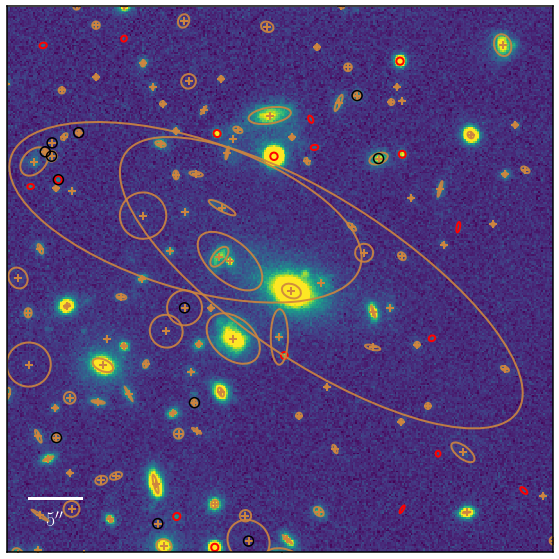

In [237]:
_ = plotting.cutout_show_objects(
    cutout, cutout_objs, xsize=10)

# 140/152 objects are clean.
# There are 20 point sources on the cutout
# There are 132 extended sources on the cutout


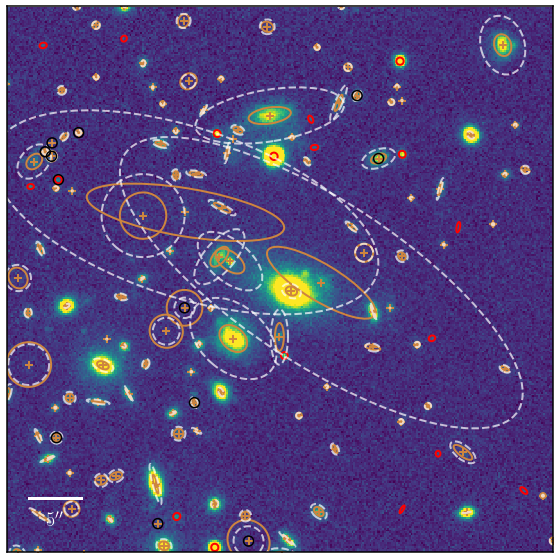

In [238]:
_ = plotting.cutout_show_objects(
    cutout, cutout_objs, xsize=10, show_weighted=False)

### Generate a model of an object based on the HSC PSF or CModel photometry

# 140/152 objects are clean.
# There are 20 point sources on the cutout
# There are 132 extended sources on the cutout


/Users/song/Dropbox/work/project/unagi/unagi/plotting.py:641: RuntimeWarning: invalid value encountered in greater_equal
/Users/song/Dropbox/work/project/unagi/unagi/plotting.py:643: RuntimeWarning: invalid value encountered in less_equal


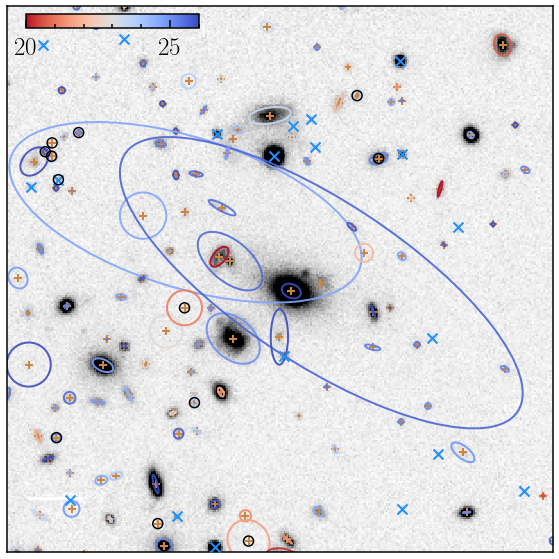

In [260]:
_ = plotting.cutout_show_objects(
    cutout, cutout_objs, xsize=10, band='i', cmap='Greys', show_mag=True)

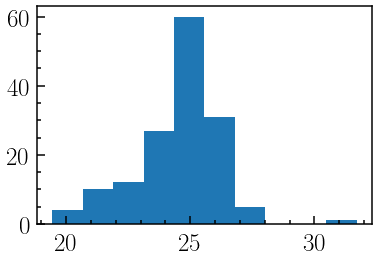

In [242]:
_ = plt.hist(cutout_objs['i_cmodel_mag'][np.isfinite(cutout_objs['i_cmodel_mag'])])

In [174]:
x_clean, y_clean = catalog.world_to_image(cutout_clean, cutout_wcs, update=False)
x_dirty, y_dirty = catalog.world_to_image(cutout_objs[~clean_mask], cutout_wcs, update=False)

# Get the stars and show the SDSS shape
star_mask = cutout_clean['i_extendedness'] < 0.5
cutout_star = cutout_clean[star_mask]
x_star, y_star = x_clean[star_mask], y_clean[star_mask]
r_star, ba_star, pa_star = catalog.moments_to_shape(
    cutout_star, shape_type='i_sdssshape', axis_ratio=True, to_pixel=True, update=False)

if len(cutout_star) > 0:
    print("# There are {} point sources on the cutout".format(len(cutout_star)))
else:
    print("# No point source is found!")

# Get the extended objects
gal_mask = ~star_mask
cutout_gal = cutout_clean[gal_mask]
x_gal, y_gal = x_clean[gal_mask], y_clean[gal_mask]
r_exp, ba_exp, pa_exp = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_exp_ellipse', axis_ratio=True, to_pixel=True, update=False)
r_dev, ba_dev, pa_dev = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_dev_ellipse', axis_ratio=True, to_pixel=True, update=False)
r_gal, ba_gal, pa_gal = catalog.moments_to_shape(
    cutout_gal, shape_type='cmodel_ellipse', axis_ratio=True, to_pixel=True, update=False)

if len(cutout_gal) > 0:
    print("# There are {} extended sources on the cutout".format(len(cutout_gal)))
else:
    print("# No point source is found!")

# There are 19 point sources on the cutout
# There are 121 extended sources on the cutout
